<a href="https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit7/unit7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 7: Robotics Simulations with PyBullet 🤖
In this small notebook you'll learn to use PyBullet today. And train two agents to walk:
- A bipedal walker 🦿
- A spider (they say Ant but come on... it's a spider 😆) 🕸️

❓ If you have questions, please post them on #study-group discord channel 👉 https://discord.gg/aYka4Yhff9

🎮 Environments: 
- `Walker2DBulletEnv-v0` 🦿
- `AntBulletEnv-v0` 🕸️

⬇️ Here is an example of what **you will achieve in just a few minutes.** ⬇️

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-Walker2DBulletEnv-v0/resolve/main/replay.mp4" type="video/mp4"></video>

In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-AntBulletEnv-v0/resolve/main/replay.mp4" type="video/mp4"></video>

💡 We advise you to use Google Colab since some environments work only with Ubuntu. The free version of Google Colab is perfect for this tutorial. Let's get started 🚀

### Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `pybullet`: Contains the `Walker2DBullet` and `AntBullet` environment 🚶
- `stable-baselines3[extra]`: The deep reinforcement learning library.
- `huggingface_sb3`: Additional code for Stable-baselines3 to load and upload models from the Hugging Face 🤗 Hub.
- `huggingface_hub`: Library allowing anyone to work with the Hub repositories.

In [ ]:
!pip install pybullet
!pip install stable-baselines3[extra]
!pip install huggingface_sb3
!pip install huggingface_hub

### Step 2: Import the packages 📦

In [ ]:
import gym
import pybullet_envs

import os

from huggingface_sb3 import load_from_hub, package_to_hub

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env

from huggingface_hub import notebook_login

import torch 
from torch import nn

### Step 3: Create the Walker2DBullet 🚶
#### The environment 🎮
In this environment, the agent needs to use correctly its different joints to walk correctly.

In [ ]:
env_id = "Walker2DBulletEnv-v0"
# Create the env
env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

We need to [normalize input features](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html) For that, a wrapper exists and will compute a running average and standard deviation of input features.

We also normalize rewards with this same wrapper by adding `norm_reward = True`

In [ ]:
env = make_vec_env("Walker2DBulletEnv-v0", n_envs=16)

# Adding this wrapper to normalize the observation and the reward
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

## Step 4: Create the PPO Model 🤖

PPO is one of the SOTA (state of the art) Deep Reinforcement Learning algorithms. 

In this case, because we have a vector as input, we'll use an MLP (multi-layer perceptron) as policy.

To find the best parameters I checked the [official trained agents by Stable-Baselines3 team](https://huggingface.co/sb3).

In [ ]:
model = PPO(policy = "MlpPolicy",
            env = env,
            batch_size = 128,
            clip_range = 0.4,
            ent_coef = 0.0,
            gae_lambda = 0.92,
            gamma = 0.99,
            learning_rate = 3.0e-05,
            max_grad_norm = 0.5,
            n_epochs = 20,
            n_steps = 512,
            policy_kwargs = dict(log_std_init=-2, ortho_init=False, activation_fn=nn.ReLU, net_arch=[dict(pi=[256,
      256], vf=[256, 256])] ),
            use_sde = True,
            sde_sample_freq = 4,
            vf_coef = 0.5,
            tensorboard_log = "./tensorboard",
            verbose=1)

### Step 5: Train the PPO agent 🏃
- Let's train our agent for 2,000,000 timesteps, don't forget to use GPU on Colab. It will take approximately ~25min

In [ ]:
model.learn(2_000_000)

In [ ]:
# Save the model and  VecNormalize statistics when saving the agent
model.save("ppo-Walker2DBulletEnv-v0")
env.save("vec_normalize.pkl")

### Step 6: Evaluate the agent 📈
- Now that's our  agent is trained, we need to **check its performance**.
- Stable-Baselines3 provides a method to do that `evaluate_policy`
- In this case, we see that's the mean reward is `2371.90 +/- 16.50`

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Load the saved statistics
eval_env = DummyVecEnv([lambda: gym.make("Walker2DBulletEnv-v0")])
eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)

#  do not update them at test time
eval_env.training = False
# reward normalization is not needed at test time
eval_env.norm_reward = False

# Load the agent
model = PPO.load("ppo-Walker2DBulletEnv-v0")

mean_reward, std_reward = evaluate_policy(model, env)

print(f"Mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")

### Step 7: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Here's an example of a Model Card:

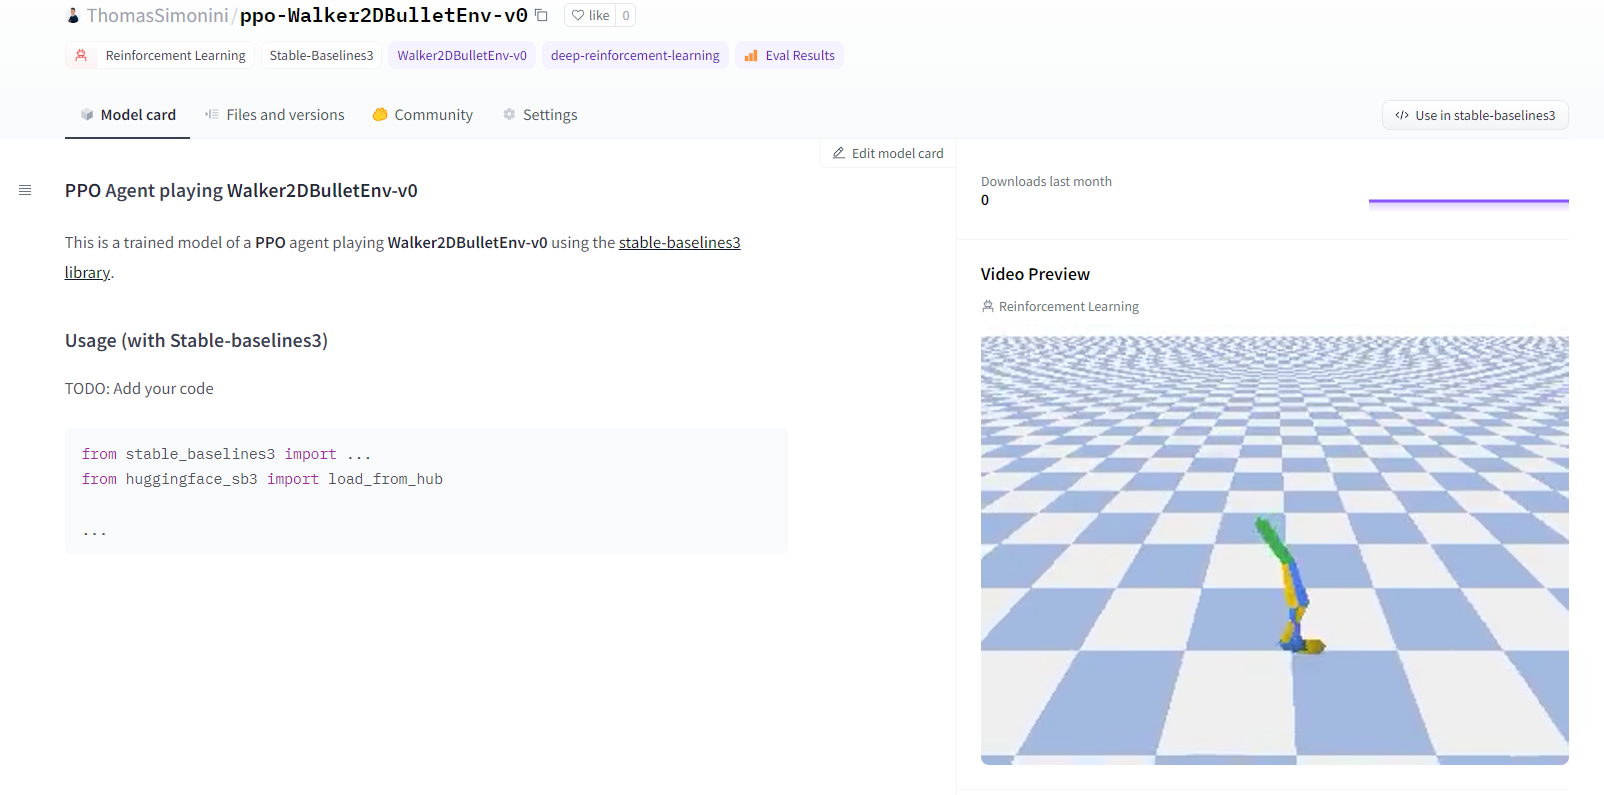

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

By using `package_to_hub` **you evaluate, record a replay, generate a model card of your agent and push it to the hub**.

This way:
- You can **showcase our work** 🔥
- You can **visualize your agent playing** 👀
- You can **share with the community an agent that others can use** 💾
- You can **access a leaderboard 🏆 to see how well your agent is performing compared to your classmates** 👉 https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

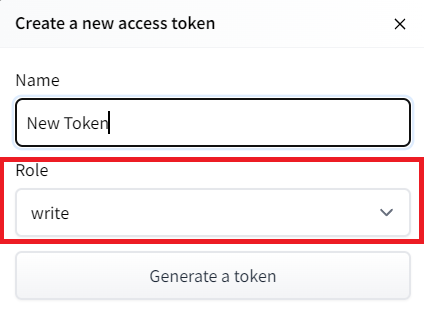

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained agent to the 🤗 Hub 🔥 using `package_to_hub()` function

In [ ]:
package_to_hub(
    model=model,
    model_name=f"ppo-{env_id}",
    model_architecture="PPO",
    env_id=env_id,
    eval_env=eval_env,
    repo_id=f"ThomasSimonini/ppo-{env_id}",
    commit_message="Initial commit",
)

## Some additional challenges 🏆
The best way to learn **is to try things by your own**! Why not trying `AntBulletEnv-v0` or `HalfCheetahBulletEnv-v0`?

In the [Leaderboard](https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard) you will find your agents. Can you get to the top?

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters by looking at what your classmates have done 👉 https://huggingface.co/models?other=Walker2DBulletEnv-v0
* **Push your new trained model** on the Hub 🔥


See you on Unit 8! 🔥
## Keep learning, stay awesome 🤗